# Operacje początkowe
Pobranie danych, importy, definicje stałych, podział na zbiór tesotwy i walidacyjny

In [1]:
!wget http://2018.poleval.pl/task3/task3_train.txt.gz

--2019-06-04 14:01:19--  http://2018.poleval.pl/task3/task3_train.txt.gz
Resolving 2018.poleval.pl (2018.poleval.pl)... 213.135.36.94
Connecting to 2018.poleval.pl (2018.poleval.pl)|213.135.36.94|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1280259946 (1.2G) [application/x-gzip]
Saving to: ‘task3_train.txt.gz’

task3_train.txt.gz  100%[===================>]   1.19G  21.0MB/s    in 67s     

2019-06-04 14:02:27 (18.2 MB/s) - ‘task3_train.txt.gz’ saved [1280259946/1280259946]



In [0]:
import gzip
import re
import random
import unicodedata
import string
from functools import reduce

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, ConcatDataset

device = torch.device("cuda")

In [0]:
MASK = 'xxxxxx'
ALL_LETTERS = string.ascii_lowercase + "ąćęłńóśżź"
N_LETTERS = len(ALL_LETTERS)

LEARNING_RATE = 0.05

WE_HIDDEN_DIM = 5
WE_MID = 10
WE_OUTPUT = 12
MLM_EMBEDDING_SIZE = 5
MLM_HIDDEN_SIZE = 7
MLM_LSTM_LAYERS = 2
MLM_FC_1 = 8
MLM_OUTPUT = 20

In [0]:
f = gzip.open('task3_train.txt.gz', 'rb')
file_content = f.read()
f.close()

In [0]:
sentences = file_content.split(b'\n')
sentences_small = sentences[:50000]
del sentences
sentences_small = [s.decode("utf-8") for s in sentences_small]
sentences_train, sentences_test = train_test_split(sentences_small,
                                                   test_size=0.2,
                                                   shuffle=True,
                                                   random_state=666)

# Klasa CorpusPreprocessor
wraz z wymaganymi metodami i kilkoma innymi

In [0]:
class CorpusPreprocessor:

    def __init__(self, corpus, mask=MASK):
        self.words = list(set(reduce((lambda x, y: x + ' ' + y),
                                     (map(self.transform_text, corpus))
                                    ).split(' ')) | {mask})
        self.words_mapping = dict(zip(self.words, range(len(self.words))))
        self.mask = mask

    @staticmethod
    def transform_text(text):
        text = text.lower()
        text = re.sub(r'[^a-ząćęłńóśżź ]', '', text)
        return ' '.join(text.split())

    def mask_text(self, text):
        words = text.split(' ')
        changed_index = random.randrange(len(words))
        original_word = words[changed_index]
        words[changed_index] = self.mask
        if random.uniform(0, 1) < 0.5:
            return ' '.join(words), original_word, 1
        else:
            return ' '.join(words), random.choice(self.words), 0
    
    @staticmethod
    def text_to_tensor(text_batch):
        lengths = [len(t) for t in text_batch]
        longest = max(lengths)
        tensor = torch.zeros(longest, len(text_batch), N_LETTERS)
        for ti, text in enumerate(text_batch):
          for li, letter in enumerate(text):
              tensor[li][ti][ALL_LETTERS.find(letter)] = 1
        return tensor, torch.tensor(lengths, requires_grad=False).reshape(-1, 1).float()
      
    def map_sentence(self, sentences_batch):
        sentences_splitted = [s.split(' ') for s in sentences_batch]
        lengths = [len(s) for s in sentences_splitted]
        longest = max(lengths)
        tensor = torch.zeros(len(sentences_batch), longest)
        for si, sentence in enumerate(sentences_splitted):
            for wi, word in enumerate(sentence):
                tensor[si][wi] = self.words_mapping.setdefault(word, -1)
        return tensor.long(), torch.tensor(lengths, requires_grad=False).reshape(-1, 1).float()

# Sieć WordEmbedder

In [0]:
class WordEmbedder(nn.Module):
    def __init__(self):
        super(WordEmbedder, self).__init__()
        self.lstm = nn.LSTM(N_LETTERS, WE_HIDDEN_DIM)
        self.fc1 = nn.Linear(WE_HIDDEN_DIM, WE_MID)
        self.fc2 = nn.Linear(WE_MID, WE_OUTPUT)

    def forward(self, words_batch):
        x, l = CorpusPreprocessor.text_to_tensor(words_batch)
        x, l = x.to(device), l.to(device)
        x, _ = self.lstm(x)
        x = x.sum(0)
        x = x / l 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Sieć MainLanguageModel

In [0]:
class MainLanguageModel(nn.Module):
    def __init__(self, corpus_preprocessor):
        super(MainLanguageModel, self).__init__()
        self.corpus_preprocessor = corpus_preprocessor
        self.embedder = nn.Embedding(len(corpus_preprocessor.words_mapping) + 1,
                                     MLM_EMBEDDING_SIZE)
        self.bi_dir_lstm = nn.LSTM(MLM_EMBEDDING_SIZE, MLM_HIDDEN_SIZE,
                                   MLM_LSTM_LAYERS, batch_first=True,
                                   bidirectional=True)
        self.fc1 = nn.Linear(2 * MLM_HIDDEN_SIZE, MLM_FC_1)
        self.fc2 = nn.Linear(WE_OUTPUT + MLM_FC_1, MLM_OUTPUT)
        

    def forward(self, embedded_word, sentences):
        x, l = self.corpus_preprocessor.map_sentence(sentences)
        x, l = x.to(device), l.to(device)
        x = self.embedder(x)
        x, _ = self.bi_dir_lstm(x)
        x = x.sum(1)
        x = x / l
        x = F.relu(self.fc1(x))
        x = torch.cat((embedded_word, x), 1)
        x = torch.tanh(self.fc2(x))
        return x

# Sieć ModelWrapper
łączy obie powyższe sieci

In [0]:
class ModelWrapper(nn.Module):
    def __init__(self, word_embedder, main_language_model):
        super().__init__()
        self.word_embedder = word_embedder
        self.main_language_model = main_language_model
        self.fc = nn.Linear(MLM_OUTPUT, 1)
        

    def forward(self, word, sentence):
        embedding = self.word_embedder(word)
        x = self.main_language_model(embedding, sentence)
        x = self.fc(x)
        return torch.sigmoid(x).reshape(-1)

# Definicje Datasetów
używanych dlaej

In [0]:
class SentencesDataset(Dataset):

    def __init__(self, sentences_list, corpus_preprocessor):

        self.sentences_list = sentences_list
        self.corpus_preprocessor = corpus_preprocessor

    def __len__(self):
        return len(self.sentences_list)

    def __getitem__(self, idx):
        sentence = self.sentences_list[idx]
        sentence = self.corpus_preprocessor.transform_text(sentence)
        return self.corpus_preprocessor.mask_text(sentence)

In [0]:
class WordsDataset(Dataset):

    def __init__(self, words_group):
        self.words = [(k, v) for k in words_group for v in words_group[k]]

    def __len__(self):
        return len(self.words)

    def __getitem__(self, idx):
        return self.words[idx]

# Stworzenie używanych zmiennych

In [0]:
we = WordEmbedder()
corpus_preprocessor = CorpusPreprocessor(sentences_small)
mlm = MainLanguageModel(corpus_preprocessor)
mw = ModelWrapper(we, mlm)

In [0]:
train_set = SentencesDataset(sentences_train, corpus_preprocessor)
train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=120,
        num_workers=0,
        shuffle=True
    )


test_set = SentencesDataset(sentences_test, corpus_preprocessor)
test_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size=120,
        num_workers=0,
        shuffle=False
    )

# Trenowanie modelu

In [0]:
def train_model(model, criterion, optimizer, num_of_epochs, train_loader, device):

    for epoch in range(num_of_epochs):  # loop over the dataset multiple times
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            data_s, data_w, data_out = data
            data_out = data_out.float().to(device)
            optimizer.zero_grad()

            outputs = model(data_w, data_s)
            
            loss = criterion(outputs, data_out)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:  # print every 100 mini-batches
                print(f'[{epoch}, {i + 1}] loss: {running_loss / 100}')
                running_loss = 0.0
        

    print('Finished Training')

In [19]:
mw.to(device)
print(mw)

train_model(
    mw,
    criterion=nn.BCELoss(),
    optimizer=optim.Adam(mw.parameters(), lr=LEARNING_RATE),
    num_of_epochs=5,
    train_loader=train_loader,
    device=device
)

ModelWrapper(
  (word_embedder): WordEmbedder(
    (lstm): LSTM(35, 5)
    (fc1): Linear(in_features=5, out_features=10, bias=True)
    (fc2): Linear(in_features=10, out_features=12, bias=True)
  )
  (main_language_model): MainLanguageModel(
    (embedder): Embedding(110895, 5)
    (bi_dir_lstm): LSTM(5, 7, num_layers=2, batch_first=True, bidirectional=True)
    (fc1): Linear(in_features=14, out_features=8, bias=True)
    (fc2): Linear(in_features=20, out_features=20, bias=True)
  )
  (fc): Linear(in_features=20, out_features=1, bias=True)
)
[0, 100] loss: 0.576072526872158
[0, 200] loss: 0.5753041034936905
[0, 300] loss: 0.5687943065166473
[1, 100] loss: 0.5711894479393959
[1, 200] loss: 0.5667075684666634
[1, 300] loss: 0.5673710539937019
[2, 100] loss: 0.5679762488603592
[2, 200] loss: 0.5653602397441864
[2, 300] loss: 0.5649529200792313
[3, 100] loss: 0.5559575811028481
[3, 200] loss: 0.5622761285305024
[3, 300] loss: 0.5668835100531578
[4, 100] loss: 0.5613222327828408
[4, 200] lo

# Walidacja modelu

In [0]:
def validate(model, valid_loader):

    model.eval()
    correct = 0
    len_tot = 0
    baseline = 0

    with torch.no_grad():
        for i, data in enumerate(valid_loader):
                data_s, data_w, data_out = data
                baseline += torch.sum(data_out).item()
                data_out = data_out.float().to(device)
                preds = model(data_w, data_s)
                correct += torch.sum((preds.round() - data_out == 0).int()).item()
                len_tot += len(preds)
    print(f'Baseline: {baseline / len_tot}')
    print(f'Accuracy: {correct / len_tot}')


In [22]:
validate(mw, test_loader)

Baseline: 0.5075
Accuracy: 0.6904


# Wizualizacje embeddingu

In [0]:
def tsne_plot(words_groups_dict, word_embedder, corpus_preprocessor,
              with_annotations=True, with_vectors=False):
    
    base_dataset = WordsDataset({' ': random.sample(corpus_preprocessor.words,
                                                    1000)})
    base_loader = torch.utils.data.DataLoader(
        base_dataset,
        batch_size=120,
        num_workers=0,
        shuffle=True
    )
    embeddings_base = []
    
    word_embedder.eval()
    with torch.no_grad():
        for i, data in enumerate(base_loader):
            _, word = data
            embedding_base = word_embedder(word)
            embeddings_base.append(embedding_base.cpu().numpy())
    embeddings_base = np.concatenate(embeddings_base)
    
    
    word_dataset = WordsDataset(words_groups_dict)
    word_loader = torch.utils.data.DataLoader(
        word_dataset,
        batch_size=120,
        num_workers=0,
        shuffle=True
    )
    
    categories = []
    words = []
    embeddings = []

    with torch.no_grad():
        for i, data in enumerate(word_loader):
            category, word = data
            categories += category
            words += word
            embedding = word_embedder(word)
            embeddings.append(embedding.cpu().numpy())
    embeddings = np.concatenate(embeddings)
    
    
    tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=4000,
                learning_rate=400)
    tsne_res = tsne.fit_transform(np.concatenate([embeddings_base, embeddings]))
    tsne_embeddings = tsne_res[len(embeddings_base):]
    
    points_labels = list(zip(categories, words, tsne_embeddings[:, 0],
                             tsne_embeddings[:, 1]))

        
    for cat in words_groups_dict:
        x_vals = [pl[2] for pl in points_labels if pl[0] == cat]
        y_vals = [pl[3] for pl in points_labels if pl[0] == cat]
        plt.scatter(x_vals, y_vals, label=cat, alpha=0.5, s=40.)
        if with_annotations:
            annotations = [pl[1] for pl in points_labels if pl[0] == cat]
            for i, txt in enumerate(annotations):
                plt.annotate(txt, (x_vals[i], y_vals[i]))
                
    if with_vectors:
        zero = [0.] * len(points_labels)
        _, _, x_vec, y_vec = list(zip(*points_labels))
        vector_coords = zip(zero, zero, x_vec, y_vec)
        for z1, z2, x, y in vector_coords:
            plt.arrow(z1, z2, x, y, head_width=0.5, head_length=0.5)
        plt.xlim(-1.1 * max(map(abs, x_vec)), 1.1 * max(map(abs, x_vec)))
        plt.ylim(-1.1 * max(map(abs, y_vec)), 1.1 * max(map(abs, y_vec)))
    plt.legend()
    plt.show()
    

## Porównanie embeddingów na różnych częściach mowy
Jak widzimy sieć potrafi po części odróżniać przymiotniki od pozostałych dwóch cześci mowy

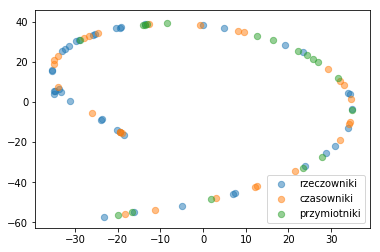

In [486]:
type_groups = {
'rzeczowniki': ['nauczyciel', 'dziecko', 'ania', 'stół', 'książka', 'spodnie', 
               'pies', 'krowa', 'mrówka', 'wierzba', 'kwiatek', 'pszenica', 
               'park', 'piwnica', 'księgarnia', 'miłość', 'mądrość',
               'zdziwienie', 'burza', 'powódź', 'wiatr', 'strażak', 'chłopiec', 
               'pisarz', 'listonosz', 'ksiądz', 'tata', 'człowiek', 'dom', 
               'wieś', 'miasto', 'kraj', 'kwiat', 'samochód', 'serce', 'świece',
               'komputer', 'pies', 'miejscowość', 'hotel'],

'czasowniki': ['pisać', 'jeść', 'czytać', 'pływać', 'biegać', 'chorować',
              'siedzieć', 'spać', 'cierpieć', 'wisieć', 'mądrzeć', 'dorastać',
              'dojrzewać', 'myśleć', 'być', 'żyć', 'pamiętać', 'potknąć', 
              'upaść', 'spaść', 'spotkać', 'uderzyć', 'błyska', 'chmurzy',
              'grzmieć', 'świecić', 'wrzeć', 'palić'],

'przymiotniki': ['drewniany', 'zielony', 'szeroki', 'francuski', 'ładny', 
                'mądry', 'grzeczny', 'wspaniały', 'brzydki', 'głupi', 
                'niegrzeczny', 'beznadziejny', 'ładniejszy', 'najładniejszy',
                'mądrzejszy', 'najmądrzejszy', 'inteligentny', 'uroczy'],
}


tsne_plot(type_groups, we, corpus_preprocessor, False)

## Porównanie embeddingów na trzech grupach zwierząt
Jak widzimy sieć potrafi dość skutecznie oddzielać zwierzęta afrykańskie od tych spotykanych w Polsce, ale podział między dzikimi i udomowionymi zwierzętami jest trudniejszy

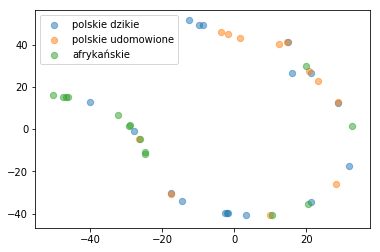

In [508]:
animals_groups = {
'polskie dzikie': ['dzik', 'wilk', 'niedźwiedź', 'żubr', 'jeż',
                   'kret', 'wiewiórka', 'bóbr', 'zając', 'lis', 'kuna', 'wydra',
                   'borsuk', 'łasica', 'jeleń', 'sarna', 'łoś', ],

'polskie udomowione': ['krowa', 'koń', 'kura', 'kaczka', 'gęś', 'owca', 'świnia',
                         'królik', 'koza', 'kot', 'pies', 'chomik'],

'afrykańskie': ['lew', 'zebra', 'żyrafa', 'hiena', 'małpa', 'guziec',
                'hipopotam', 'nosorożec', 'antylopa', 'gepard', 'gnu',
                'surykatka', 'bawół', 'gazela'],

}


tsne_plot(animals_groups, we, corpus_preprocessor, False, False)

## Porównanie embeddingów na trzech grupach cech przemiotów
Jak widzimy sieć potrafi nie potrafi uogólniać cech przedmiotów do wspólnych kategorii

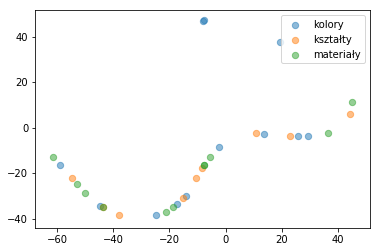

In [513]:
features_groups = {
'kolory': ['niebieskie', 'zielone', 'czerwone', 'żółte', 'czarne', 'białe', 
           'złote', 'fioletowe', 'różowe', 'pomarańczowe', 'srebrne', 'brązowe'],

'kształty': ['okrągłe', 'kwadratowe', 'prostokątne', 'stożkowate', 'podłużne',
             'kuliste', 'trójkątne', 'nieregularne', 'wygięte'],

'materiały': ['drewniane', 'metalowe', 'porcelanowe', 'plastikowe', 'papierowe',
              'stalowe', 'betonowe', 'kamienne', 'gliniane', 'marmurowe',
              'lniane'],

}


tsne_plot(features_groups, we, corpus_preprocessor, False, False)

## Porównanie embeddingów na grupach słów o przeciwnym znaczeniu
Jak widzimy sieć zauważa w mniejszym lub większym stopniu przeciwieństwa odpowiednich słów

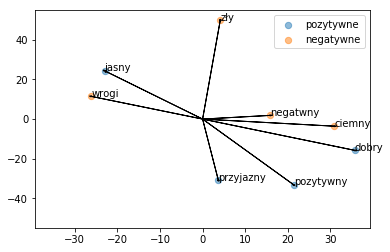

In [509]:
opposites_groups_1 = {
  'pozytywne': ['dobry', 'jasny', 'pozytywny', 'przyjazny'],
  'negatywne': ['zły', 'ciemny', 'negatwny', 'wrogi'],
}

tsne_plot(opposites_groups_1, we, corpus_preprocessor, True, True)


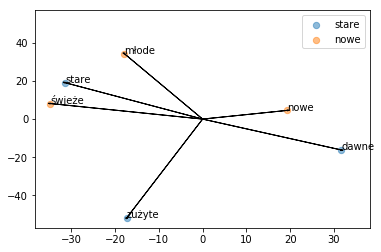

In [510]:
opposites_groups_2 = {
  'stare': ['stare', 'dawne', 'zużyte'],
  'nowe': ['nowe', 'młode', 'świeże'],
}

tsne_plot(opposites_groups_2, we, corpus_preprocessor, True, True)



## Porównanie embeddingów na grupach słów o wspólnym rdzeniu
Jak widzimy sieć wykrywa wspólny rdzeń w pewnych słowach, ale w innych ma z tym problem

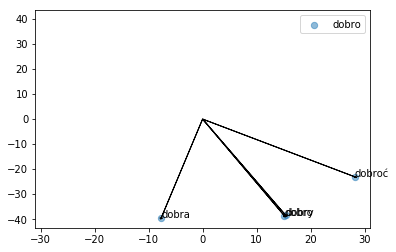

In [497]:
common_core_groups_1 = {
  'dobro': ['dobry', 'dobro', 'dobroć', 'dobra']
}

tsne_plot(common_core_groups_1, we, corpus_preprocessor, True, True)

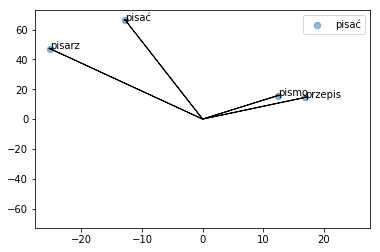

In [500]:
common_core_groups_2 = {
  'pisać': ['pisać', 'pismo', 'pisarz', 'przepis']
}

tsne_plot(common_core_groups_2, we, corpus_preprocessor, True, True)

## Porównanie embeddingów na grupach słów różniących się  "o ten sam wektor"
Jak widzimy sieć nie potrafi wykryć wektora przenoszącego rolę żenską do męskiej, ale potrafi wykryć wektor przenoszący analogie między państwami

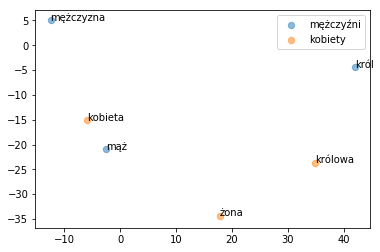

In [512]:
men_women_groups = {
  'mężczyźni': ['mąż', 'mężczyzna', 'król'],
  'kobiety': ['żona', 'kobieta', 'królowa']
}

tsne_plot(men_women_groups, we, corpus_preprocessor, True, False)

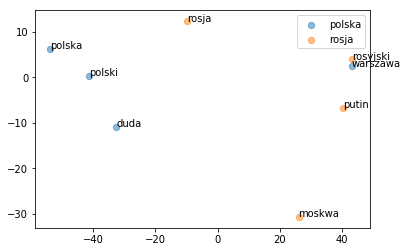

In [502]:
countries_groups = {
  'polska': ['polska', 'polski', 'warszawa', 'duda'],
  'rosja': ['rosja', 'rosyjski', 'moskwa', 'putin']
}

tsne_plot(countries_groups, we, corpus_preprocessor, True, False)

## Porównanie embeddingów na grupach będących synonimami
jak widzimy sieć niezbyt dobrze zauważa synonimy

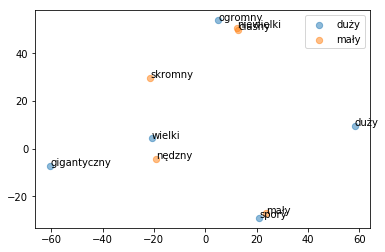

In [504]:
synonimes_groups = {
    'duży': ['duży', 'wielki', 'ogromny', 'spory', 'gigantyczny'],
    'mały': ['mały', 'skromny', 'niewielki', 'ciasny', 'nędzny']
}
tsne_plot(synonimes_groups, we, corpus_preprocessor, True, False)